In [3]:
from datasets import SOCOFingGender, SOCOFingFingers, SOCOFingSubjects, SOCOFingHeands, QFing, NISTDB4Gender, NISTDB4Type
# import FPMLmodule.backbones as backbones
# import FPMLmodule.classifiers as classifiers
# from FPMLmodule.fpml import FPML 
import FPMLmodule.utils as utils
# import numpy as np
from matplotlib import pyplot as plt
# # from keras import layers, Sequential, models
# from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
import tensorflow as tf
import numpy as np
import os
# print("Tensorflow version " + tf.__version__)

In [4]:
# Global Config
seed=9
imgDim = (224, 224, 3)
imgHeight, imgWidth, imgChannels = imgDim
batchSize = 32

# Dataset configuration
dsConfig = {
    'batchSize': batchSize, 
    'parallelTune': tf.data.AUTOTUNE, 
    'split': [0.7, 0.15, 0.15], 
    'inputDim': imgDim, 
    'seed': seed, 
    'shuffle': True
    }

weightsRN50 = "./weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
weightsMNV2 = "./weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"
weightsENB2 = "./weights/efficientnetb2_notop.h5"
weightsINCEPTIONV3 = "./weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weightsXCEPTION = "./weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Training interval
epochsForSearch = 10
epochsForBest = 100

In [9]:
SOCOGender = SOCOFingGender(**dict(dsConfig, sampling=SOCOFingGender.UNDER_SAMPLING))
SOCOSubjects = SOCOFingSubjects(**dsConfig)
SOCOFingers = SOCOFingFingers(**dsConfig)
QualityFing = QFing(**dsConfig)
SOCOHeands = SOCOFingHeands(**dsConfig)
NISTGender = NISTDB4Gender(**dsConfig)
NISType = NISTDB4Type(**dsConfig)


genderDS = SOCOGender.create()
subjectDS = SOCOSubjects.create()
fingersDS = SOCOFingers.create()
heandsDS = SOCOHeands.create()
qfingDS = QualityFing.create()
nistGenderDS = NISTGender.create()
nistTypeDS = NISType.create()

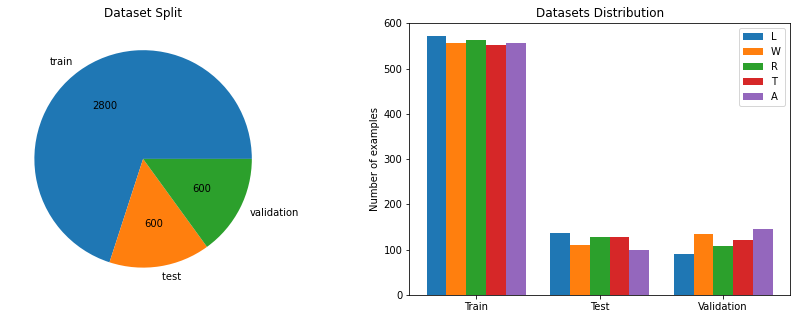

In [10]:
utils.displayDatasetSplitInformation(nistTypeDS, NISType.classNames)
# for ds in nistGenderDS:
#     print(utils.datasetDistribution(ds))

In [5]:
train_ds, test_ds, val_ds = genderDS
nbClasses = len(SOCOGender.classNames)
activation = "softmax"

hypers = {
    "optimizer": Adam,
    "learningRate": 0.001,
    "loss": 'binary_crossentropy',
    "metrics": 'accuracy'
}
optimizerStudy = {
    "ResNet50" : {
        "architecture": {
            "backbone": [
                backbones.ResNet50(imgDim, weights=weightsRN50, trainable=False),
                backbones.ResNet50(imgDim, weights=weightsRN50, trainable=False)
                ],
            "classfier": classifiers.DefaultClassifier(nbClasses, activation),
            "inputLayer": None, 
            "inputDim": imgDim
        },
        "hyperparameters":hypers
    },
}


NameError: name 'Adam' is not defined

In [ ]:
encaps = utils.researchStudies(train_ds, val_ds, optimizerStudy, 1)
for enc in encaps:
    print(enc)
    

In [ ]:
utils.displayStudiesProgress(encaps)